# Exp F for the Classical SRNN (mcs)

This is a notebook for testing the classical SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from ClassicalModels.ClassicalSRNNs import ClassicalSRNN
from ClassicalModels.ClassicalSRNNs import SuportFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
from GradientFreeOptimizers.Optimizers import MCSOptimizer
import GradientFreeOptimizers.Helpers as hp

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..','data','HenonMap','Exp')
filename='QExp1.csv'

In [6]:
'''
hmap=HenonMapDataGen(savepath=savepath)
hmap(10000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 1000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.0052160710202766025, 0.048900543744267284]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=10
batchSize=16

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,mask=0,shuffle=False)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))

Train Data Size: 64


In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))


Test Data Size: 16


### Define the SRNN

#### Get neccesary functions

In [13]:
srnnExpSup=SuportFunction()

In [14]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [15]:
init_rnn_state=srnnExpSup.get_init_state_fun()
get_params=srnnExpSup.get_get_params_fun()
rnn=srnnExpSup.get_forward_fn_fun()
predict_fun=srnnExpSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [16]:
inputSize=outputSize=1
hiddenSize=2

In [17]:
net=ClassicalSRNN(inputSize,hiddenSize,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [18]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0].shape

(torch.Size([160, 1]), 1, torch.Size([16, 2]))

In [19]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0052],
        [0.0489]])
preY= [tensor([0.0052]), tensor([0.0489]), tensor([0.9982]), tensor([-0.3803]), tensor([1.0969]), tensor([-0.7987]), tensor([0.4360]), tensor([0.4943]), tensor([0.7888]), tensor([0.2772]), tensor([1.1291])]


In [20]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0052), tensor(0.0489), tensor(-5.9977e-06), tensor(1.2131e-07), tensor(-1.7208e-09), tensor(2.7569e-11), tensor(-4.2227e-13)]


### Train the network

#### Parameters

In [21]:
num_epochs= 300
step_epochs=10

In [22]:
#maxLevyStepSize=[1.0,1.0,0.1,1.0,1.0]
maxLevyStepSize=[0.2]*5

#### Loss function

In [23]:
lossFunc=GradFreeMSELoss(net)

#### Trainer

In [24]:
mcs=MCSOptimizer(net.params,lossFunc,trainIter,\
    maxLevyStepSize=maxLevyStepSize,randInit=True,\
    nestNum=40,epochToGeneration=lambda x:max(int(x/100),1))

#### Initial loss

In [25]:
l_epochs=[]
train_l=SuportFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=SuportFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5891363859176636
Initial Test Loss: 0.5889654636383057


#### Training

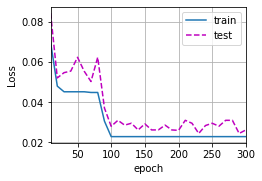

In [26]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'], xlim=[10, num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    with torch.no_grad():
        trainLoss,_ = mcs.step()
        testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
        if (epoch + 1) % step_epochs == 0:
            print(f'TestLoss {testLoss:f}')
            animator.add(epoch + 1, [trainLoss,testLoss])
        l_epochs.append([trainLoss,testLoss])
testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)

In [27]:
l_epochs[-1]

[0.02286127209663391, 0.026196762919425964]

### Visualize the performance

#### One Step Prediction

In [28]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
#print('X=',torch.squeeze(X))
#print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
#print('Y=',torch.squeeze(Y))



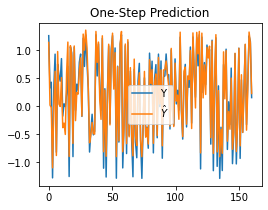

In [29]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [30]:
prefixSize=10
totalSize=20
testShift=int(len(hmap)*(1-testSetRatio))

In [31]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

20

In [32]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

20

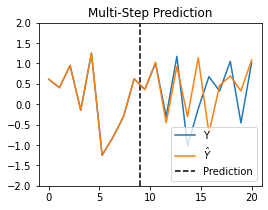

In [33]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();

# End of the test